### Compute features from SQL to study its imapct on execution time

#### The following features are computed and analyzed

* Type of query
* Number of fields requested
* Number of tables accessed
* Depth of query (number of sub-queries)

In [510]:
import sqlparse as sp
import numpy as np
import pandas as pd
import pylab as P
import math as m
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

data = pd.read_csv ('/data/developer/python/exec_time.csv',sep = '@',names = ['query','exec_time'])
data1=data.copy()
data.exec_time = pd.to_numeric(data.exec_time,errors='coerce')
data.query=data['query'].apply(np.frompyfunc(lambda x : sp.parse(x),1,1))

In [511]:
data['stmttype'] = 0

In [512]:
for i in range (0,len(data)):
    data.loc[i,('stmttype')] = data.query[i].get_type()
    i = i + 1

In [513]:
data['numfields'] = 0

In [514]:
for i in range (0,len(data)):
    parsed_query = [t.to_unicode() for t in data.query[i].tokens if t.ttype is None]
    if (len(parsed_query) > 0):
         if (data.query[i].get_type() == 'SELECT'):
            data.loc[i,('numfields')] = len(parsed_query[0].split(','))
         if (data.query[i].get_type() == 'INSERT'):
            if (len(parsed_query[0].split('(')) > 1):
                data.loc[i,('numfields')] = len(parsed_query[0].split('(')[1].split(','))
            else:
                data.loc[i,('numfields')] = len(parsed_query[1].split(','))
         if (data.query[i].get_type() == 'UPDATE'):
            data.loc[i,('numfields')] = len(parsed_query[1].split(','))
         if (data.query[i].get_type() == 'DELETE'):
            data.loc[i,('numfields')] = 0
    i = i + 1

In [515]:
data['numtables'] = 0

In [516]:
for i in range (0,len(data)):
    if (len(parsed_query) > 1):
        if (data.query[i].get_type() == 'SELECT'):
            numtables = 0
            splitjoin = data.query[i].to_unicode().upper().split(' JOIN ')
            for setoftables in splitjoin:
                splitfrom = setoftables.split(' FROM ')
                numtables = numtables + len(splitfrom[len(splitfrom)-1].split(' WHERE ')[0].split(')')[0].split(','))
            data.loc[i,('numtables')] = numtables
        else:
            data.loc[i,('numtables')] = 1
    else:
        data.loc[i,('numtables')] = 1
    i = i + 1

In [517]:
data['querydepth'] = 0

In [615]:
for i in range (0,len(data)):
    if (len(parsed_query) > 1):
        data.loc[i,('querydepth')] = len(data.query[i].to_unicode().upper().split( ' FROM ')) - 1

In [676]:
data['logexectime'] = 0
for i in range (0,len(data)):
    if data.loc[i,('exec_time')] > 0:
        data.loc[i,('logexectime')] = m.log10(data.loc[i,('exec_time')])
data['lognumtables'] = 0
for i in range (0,len(data)):
    if data.loc[i,('numtables')] > 0:
        data.loc[i,('logenumtable')] = m.log10(data.loc[i,('numtables')])
data['lognumfields'] = 0
for i in range (0,len(data)):
    if data.loc[i,('numfields')] > 0:
        data.loc[i,('lognumfields')] = m.log10(data.loc[i,('numfields')])
data['logquerydepth'] = 0
for i in range (0,len(data)):
    if data.loc[i,('querydepth')] > 0:
        data.loc[i,('logquerydepth')] = m.log10(data.loc[i,('querydepth')])

### Below we look at the impact of the features , if any,  on the distribution of the execution time  

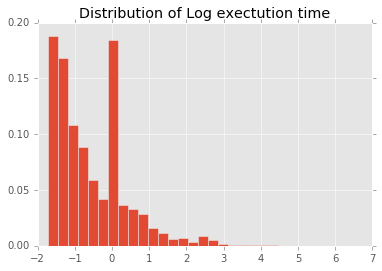

In [828]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots()
axes.hist(data.logexectime,bins=30,weights=np.zeros_like(data.logexectime) + 1. / data.logexectime.size)
axes.set_title("Distribution of Log exectution time")

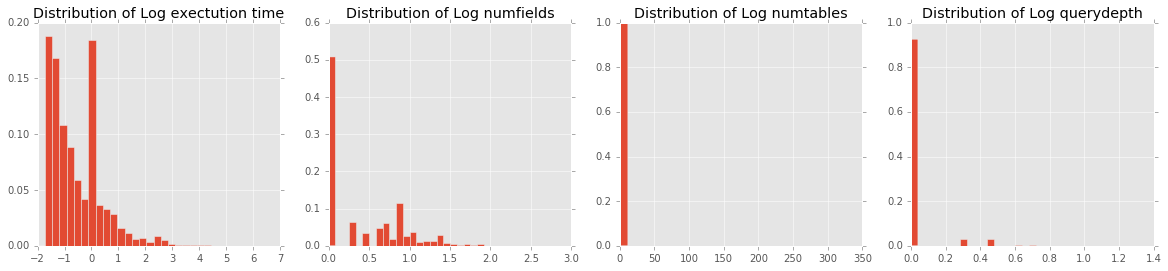

In [788]:
fig,axes = plt.subplots(1,4,figsize=(20,4))
axes[0].hist(data.logexectime,bins=30,weights=np.zeros_like(data.logexectime) + 1. / data.logexectime.size)
axes[0].set_title("Distribution of Log exectution time")
axes[1].hist([data.lognumfields],bins=30,weights=np.zeros_like(data.lognumfields) + 1. / data.lognumfields.size)
axes[1].set_title("Distribution of Log numfields")
axes[2].hist([data.numtables],bins=30,weights=np.zeros_like(data.lognumtables) + 1. / data.lognumtables.size)
axes[2].set_title("Distribution of Log numtables")
axes[3].hist([data.logquerydepth],bins=30,weights=np.zeros_like(data.logquerydepth) + 1. / data.logquerydepth.size)
axes[3].set_title("Distribution of Log querydepth")


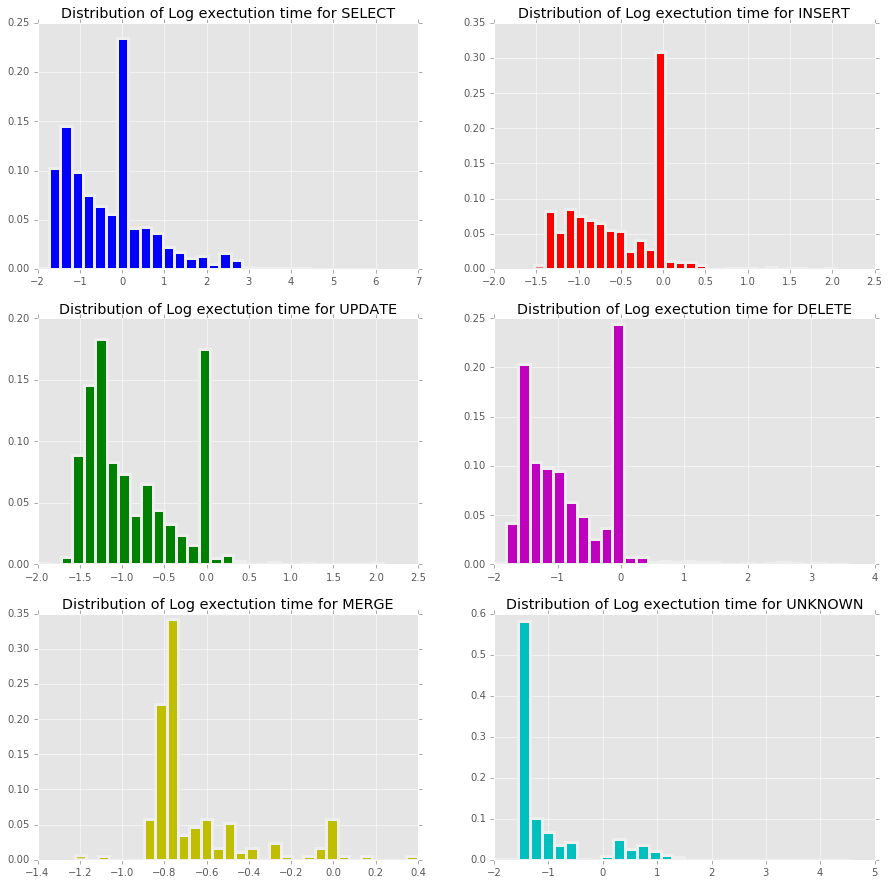

In [847]:
fig,axes = plt.subplots(3,2,figsize=(15,15))
select_data = data[data.stmttype=='SELECT']
axes[0][0].hist([select_data.logexectime],bins=30, lw=3, color= 'b',weights=np.zeros_like(select_data.logexectime) + 1. / select_data.logexectime.size)
axes[0][0].set_title("Distribution of Log exectution time for SELECT")

insert_data = data[data.stmttype=='INSERT']
axes[0][1].hist([insert_data.logexectime],bins=30, lw=3, color= 'r',weights=np.zeros_like(insert_data.logexectime) + 1. / insert_data.logexectime.size)
axes[0][1].set_title("Distribution of Log exectution time for INSERT")

update_data = data[data.stmttype=='UPDATE']
axes[1][0].hist([update_data.logexectime],bins=30, lw=3, color= 'g',weights=np.zeros_like(update_data.logexectime) + 1. / update_data.logexectime.size)
axes[1][0].set_title("Distribution of Log exectution time for UPDATE")

delete_data = data[data.stmttype=='DELETE']
axes[1][1].hist([delete_data.logexectime],bins=30, lw=3, color= 'm',weights=np.zeros_like(delete_data.logexectime) + 1. / delete_data.logexectime.size)
axes[1][1].set_title("Distribution of Log exectution time for DELETE")

merge_data = data[data.stmttype=='MERGE']
axes[2][0].hist([merge_data.logexectime],bins=30, lw=3, color= 'y',weights=np.zeros_like(merge_data.logexectime) + 1. / merge_data.logexectime.size)
axes[2][0].set_title("Distribution of Log exectution time for MERGE")

unknown_data = data[data.stmttype=='UNKNOWN']
axes[2][1].hist([unknown_data.logexectime],bins=30, lw=3, color= 'c',weights=np.zeros_like(unknown_data.logexectime) + 1. / unknown_data.logexectime.size)
axes[2][1].set_title("Distribution of Log exectution time for UNKNOWN")

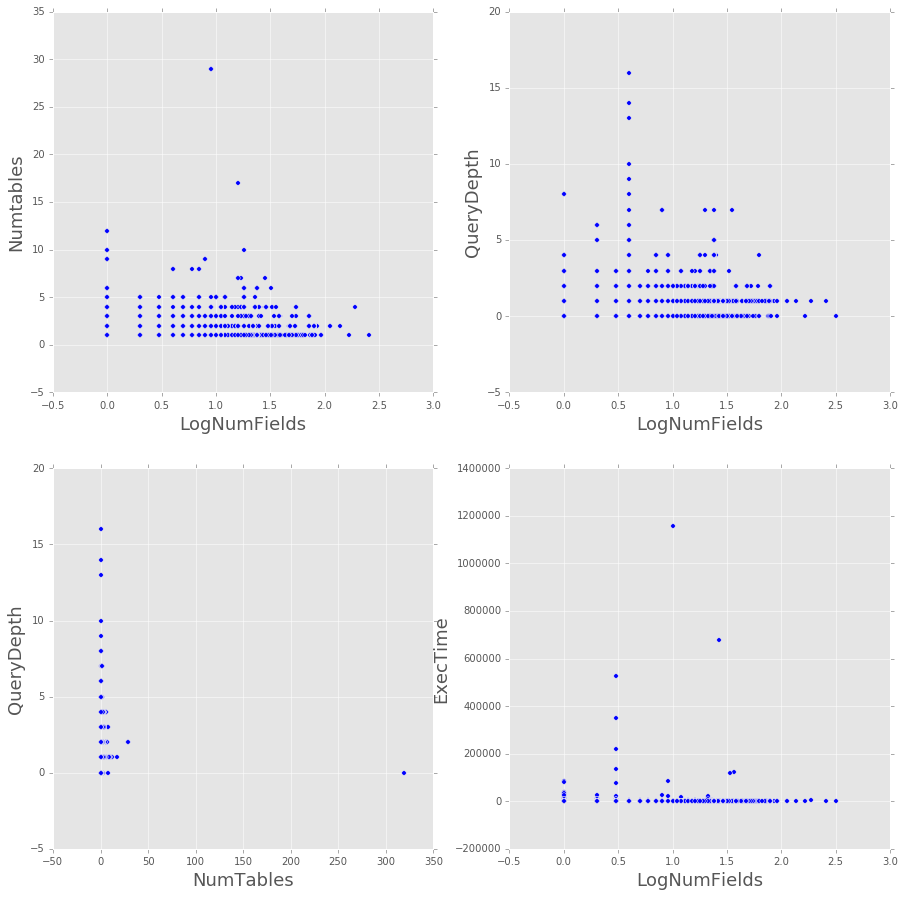

In [894]:
fig,axes = plt.subplots(2,2,figsize = (15,15))
axes[0][0].set_xlabel('LogNumFields' , fontsize=18)
axes[0][0].set_ylabel('Numtables' , fontsize=18)
axes[0][0].scatter(data[data.numtables<100].lognumfields,data[data.numtables<100].numtables)
axes[0][1].set_xlabel('LogNumFields' , fontsize=18)
axes[0][1].set_ylabel('QueryDepth' , fontsize=18)
axes[0][1].scatter(data.lognumfields,data.querydepth)
axes[1][0].set_xlabel('NumTables' , fontsize=18)
axes[1][0].set_ylabel('QueryDepth' , fontsize=18)
axes[1][0].scatter(data.numtables,data.querydepth)
axes[1][1].set_xlabel('LogNumFields' , fontsize=18)
axes[1][1].set_ylabel('ExecTime' , fontsize=18)
axes[1][1].scatter(data.lognumfields,data.exec_time)
